In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        self.chosen_features_to_take = [0, 5, 10, 19, 28] # - conv layers indexes from which to take the features
        self.model = models.vgg19(pretrained=True).features[:29]
        
    def forward(self, x):
        features = []
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if layer_num in self.chosen_features_to_take:
                features.append(x)
        
        return features

In [3]:
def load_image(image_path, resize_size, device):
    transform = transforms.Compose([
        transforms.Resize((resize_size[0], resize_size[1])),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    image = transform(image)
    
    return image.to(device)

In [4]:
TRUE_IMAGE_PATH = 'cat.jpg'
STYLE_IMAGE_PATH = 'aivazovsky.png'
RESIZING_SIZE_1 = int(1200/2)  # - height of original image
RESIZING_SIZE_2 = int(1200/2)  # - width of original image
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TOTAL_STEPS = 4001
LR = 0.001
ALPHA = 1
BETA = 0.01

In [5]:
original_img = load_image(TRUE_IMAGE_PATH, (RESIZING_SIZE_1, RESIZING_SIZE_2), DEVICE)
style_img = load_image(STYLE_IMAGE_PATH, (RESIZING_SIZE_1, RESIZING_SIZE_2), DEVICE)

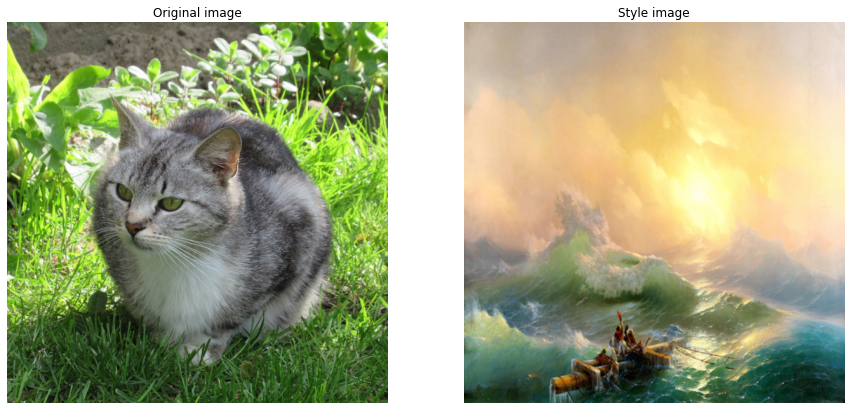

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(np.transpose(original_img.cpu(), (1, 2, 0)))
axes[0].axis('off')
axes[0].set_title('Original image')
axes[1].imshow(np.transpose(style_img.cpu(), (1, 2, 0)))
axes[1].axis('off')
axes[1].set_title('Style image')
plt.show()

In [7]:
generated = original_img.clone().requires_grad_(True)

In [8]:
model = VGG().to(DEVICE)
optimizer = optim.Adam([generated], lr=LR)

In [9]:
for step in tqdm(range(TOTAL_STEPS)):
    generated_features = model(generated)
    original_features = model(original_img)
    style_features = model(style_img)
    
    style_loss = original_loss = 0
    
    for generated_feature, original_feature, style_feature in zip(
        generated_features, original_features, style_features
    ):
        channels, height, width = generated_feature.shape
        original_loss += torch.mean((generated_feature - original_feature)**2)
        
        gram_matrix_generated = generated_feature.view(channels, height*width).mm(
            generated_feature.view(channels, height*width).t()
        )
        gram_matrix_style = style_feature.view(channels, height*width).mm(
            style_feature.view(channels, height*width).t()
        )
        style_loss += torch.mean((gram_matrix_generated - gram_matrix_style)**2)
    
    del generated_features, original_features, style_features
    total_loss = ALPHA*original_loss + BETA*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % 1000 == 0:
        print(f'Total loss on step {step}: {total_loss.item()}')
        save_image(generated, f'generated_{step}.png')

  0%|          | 0/4001 [00:00<?, ?it/s]

Total loss on step 0: 3738209.75
Total loss on step 1000: 44885.4453125
Total loss on step 2000: 25730.380859375
Total loss on step 3000: 13909.708984375
Total loss on step 4000: 6233.31298828125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


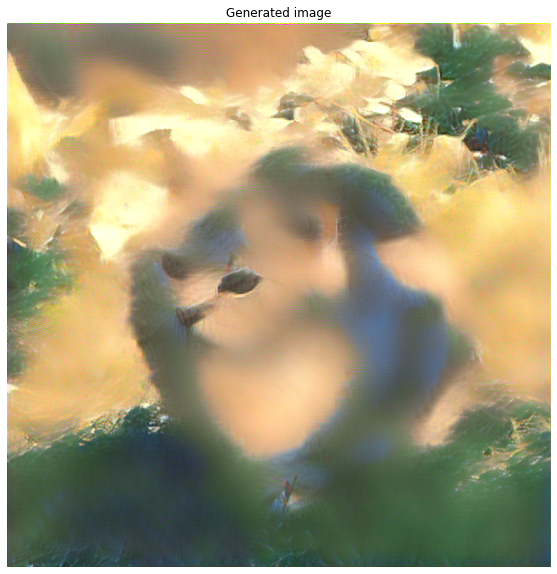

In [11]:
plt.figure(figsize=(15, 10))
plt.imshow(np.transpose(generated.detach().cpu(), (1, 2, 0)))
plt.axis('off')
plt.title('Generated image')
plt.show()